In [5]:
# With this cell any imported module is reloaded before each cell execution
%load_ext autoreload
%autoreload 2
from modules.data.load.loaders import GraphLoader
from modules.data.preprocess.preprocessor import PreProcessor
from modules.utils.utils import (
    describe_data,
    load_dataset_config,
    load_model_config,
    load_transform_config,
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
dataset_name = "QM9"
dataset_config = load_dataset_config(dataset_name)
loader = GraphLoader(dataset_config)


Dataset configuration for QM9:

{'data_domain': 'graph',
 'data_type': 'QM9',
 'data_name': 'QM9',
 'data_dir': 'datasets/graph/QM9',
 'num_features': 15,
 'num_classes': 19,
 'task': 'regression',
 'loss_type': 'mean_absolute_error',
 'monitor_metric': 'accuracy',
 'task_level': 'graph'}



Dataset contains 130831 samples.

Providing more details about sample 0/130831:


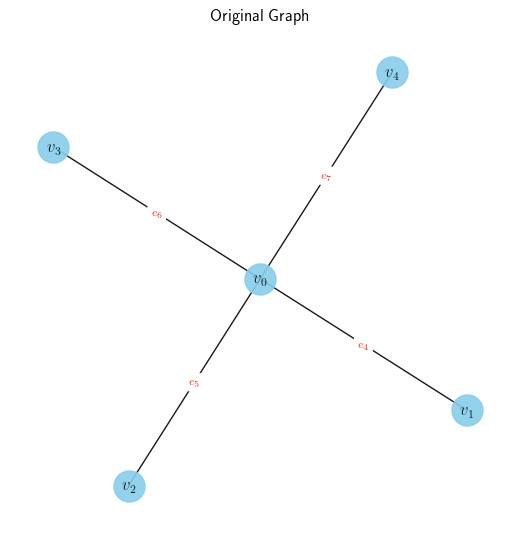

 - Graph with 5 vertices and 8 edges.
 - Features dimensions: [11, 4]
 - There are 0 isolated nodes.



In [7]:

dataset = loader.load()
describe_data(dataset)

In [8]:

transform_type = "liftings"
# If the transform is a topological lifting, it should include both the type of the lifting and the identifier
transform_id = "graph2simplicial/vietoris_rips_lifting"

# Read yaml file
transform_config = {
    "preproc": load_transform_config('data_manipulations', 'input_preproc'),
    "lifting": load_transform_config(transform_type, transform_id),
    "postproc": load_transform_config('data_manipulations', 'label_preproc'),
}


Transform configuration for data_manipulations/input_preproc:

{'transform_name': 'InputPreproc', 'transform_type': 'data manipulation'}

Transform configuration for graph2simplicial/vietoris_rips_lifting:

{'transform_type': 'lifting',
 'transform_name': 'SimplicialVietorisRipsLifting',
 'complex_dim': 2,
 'preserve_edge_attr': False,
 'signed': False,
 'feature_lifting': 'ProjectionElementWiseMean',
 'delta': 3}

Transform configuration for data_manipulations/label_preproc:

{'transform_name': 'LabelPreproc',
 'transform_type': 'data manipulation',
 'target_name': 'alpha',
 'qm9_to_ev': {'U0': 27.2114, 'U': 27.2114, 'G': 27.2114, 'H': 27.2114, 'zpve': 27211.4, 'gap': 27.2114, 'homo': 27.2114, "lumo'": 27.2114},
 'targets': ['mu', 'alpha', 'homo', 'lumo', 'gap', 'r2', 'zpve', 'U0', 'U', 'H', 'G', 'Cv', 'U0_atom', 'U_atom', 'H_atom', 'G_atom', 'A', 'B', 'C']}


In [9]:
dataset = dataset.index_select([0, 1, 2, 3, 4, 5])

In [10]:
lifted_dataset = PreProcessor(dataset, transform_config, loader.data_dir)

Processing...
/Users/martincarrasco/miniconda3/envs/topox/lib/python3.11/site-packages/scipy/sparse/_index.py:143: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
Done!



Dataset contains 6 samples.

Providing more details about sample 0/6:


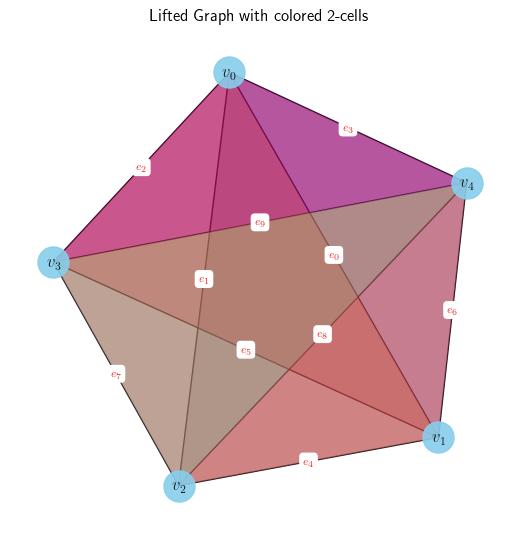

 - The complex has 5 0-cells.
 - The 0-cells have features dimension 15
 - The complex has 10 1-cells.
 - The 1-cells have features dimension 15
 - The complex has 10 2-cells.
 - The 2-cells have features dimension 15



In [11]:
describe_data(lifted_dataset)

In [12]:
from modules.models.simplicial.empsn import EMPSNModel

model_type = "simplicial"
model_id = "empsn"
model_config = load_model_config(model_type, model_id)

model = EMPSNModel(model_config, dataset_config)


Model configuration for simplicial EMPSN:

{'in_channels': None,
 'hidden_channels': 77,
 'out_channels': None,
 'n_layers': 7,
 'max_dim': 2,
 'inv_dims': {'rank_0': {'rank_0': 3, 'rank_1': 3}, 'rank_1': {'rank_1': 6, 'rank_2': 6}}}


In [15]:
from torch_geometric.data import DataLoader
follow = [f"x_{i}" for i in range(model_config['max_dim']+1)] + ['x']
train_loader = DataLoader(lifted_dataset, batch_size=1, num_workers=0, shuffle=True, follow_batch=follow)

In [17]:
batch = next(iter(train_loader))
y_hat = model(batch)

tensor([-0.0051, -0.0403,  0.0524, -0.0712, -0.0728,  0.0704, -0.0023,  0.0633,
        -0.0942,  0.0397, -0.1850,  0.0597, -0.0604, -0.0321,  0.1404,  0.0654,
         0.0618,  0.0659, -0.0645], grad_fn=<SqueezeBackward0>)
